# <b> <span style='color:#F1C40F'>|</span> Play Groud 3.2</b>

# <b> <span style='color:#F1C40F'>|</span> Table of Contents</b>

* [1 | Missing Values](#1)<br>
* [2 | KNN Imputation for Missing Values ](#2)
* [3 | Plots](#3)<br>
* [4 | Pre processing ](#4)<br>
* [5 | Model ](#5)<br>
    - [5.1 | CatBoost ](#51)<br>
    - [5.2 | Tensorflow ](#52)<br>
* [7 | Submission](#7)<br>
* [8 | Inspiration](#8)<br>

In [1]:
import numpy as np 
import pandas as pd

import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings("ignore")
import gc

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error as mae

from umap import UMAP
from sklearn.neighbors import LocalOutlierFactor

import optuna
import catboost as cb

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Input

pd.set_option('display.max_columns', None)
pd.set_option('display.max_columns', None)
plt.style.use('fivethirtyeight')
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.width', 1000)

seed = 33
np.random.seed(seed)
tf.random.set_seed(seed)


train = pd.read_csv('/kaggle/input/playground-series-s3e2/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e2/test.csv')
submission = pd.read_csv('/kaggle/input/playground-series-s3e2/sample_submission.csv')
extra_data = pd.read_csv('/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')

train.drop('id', axis=1, inplace=True)
extra_data.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

ModuleNotFoundError: No module named 'tensorflow_addons'

<a id="1"></a>
# <b>1 </b><b> <span style='color:#F1C40F'>|</span> Missing Values</b>

In [7]:
train.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [8]:
test.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
dtype: int64

In [22]:
extra_data.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

<a id="2"></a>
# <b>2 </b><b> <span style='color:#F1C40F'>|</span> KNN Imputation for Missing Values </b>

In [17]:
# Coluns Numericas
num_cols = test.select_dtypes(include=np.number).columns.tolist()
# Remove colunas categorias apesar de serem numericas
num_cols.remove('hypertension')
num_cols.remove('heart_disease')
# Colunas categoricas
cat_cols = list(set(test.columns) - set(num_cols))
# Copia
df = extra_data.copy()
# Text to number
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
# Get some columns    
cols = ['age', 'ever_married', 'work_type', 'smoking_status', 'avg_glucose_level', 'hypertension', 'heart_disease']
# KKN Model
knn = KNeighborsRegressor(n_neighbors=100, metric='minkowski', n_jobs=-1)
# Fit Model
knn.fit(df[cols], df.index)
# Aplica o medelo
dists, nears = knn.kneighbors(df[cols], return_distance=True)

# Check results
result = []
for i, n in enumerate(nears):
    n = list(n) # Value
    n.remove(i) 
    try:
        avg_bmi = df.iloc[n]['bmi'].median()
        result.append(mae(np.array([df.iloc[i]['bmi']]), np.array([avg_bmi])))
    except:
        continue

print(f'MAE mean score: {round(np.mean(result), 2)}')
print(f'MAE median score: {round(np.median(result), 2)}')        

# Restore missing values
result = []
for i in df.query('bmi!=bmi').index:
    result.append(round(df.iloc[nears[i]]['bmi'].median(),1))
df.loc[extra_data.query('bmi!=bmi').index, 'bmi'] = result
extra_data['bmi'] = df['bmi']

<a id="3"></a>
# <b>3 </b><b> <span style='color:#F1C40F'>|</span> Plots</b>

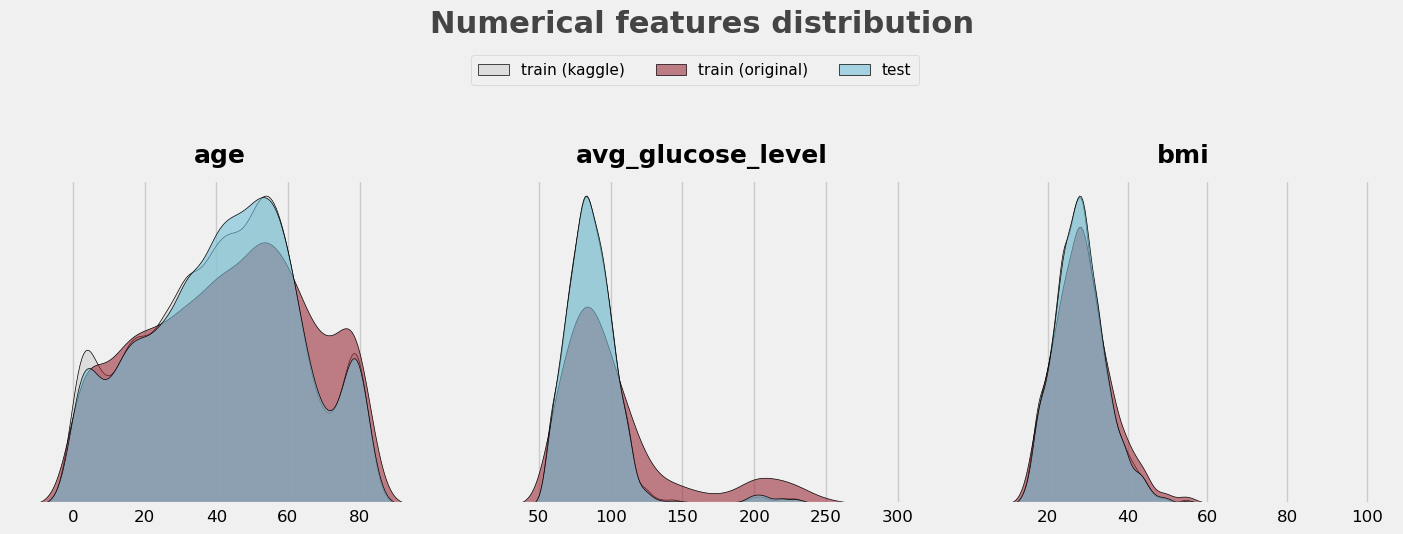

In [30]:
fig = plt.figure(figsize = (15, 5))
for i, col in enumerate(num_cols):
    plt.subplot(1,3,i+1)
    plt.title(col, size=18, y=1.03, fontname='Calibri', fontweight='bold')
    a = sns.kdeplot(train[col], color='#d1d1d1', shade=True, label='train kaggle', alpha=0.6, edgecolor='black')
    sns.kdeplot(extra_data[col], color='#9c2f3b', shade=True, label='train original', alpha=0.6, edgecolor='black')
    sns.kdeplot(test[col], color='#72bfd6', shade=True, label='test', alpha=0.6, edgecolor='black')
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks(fontname='Calibri', size=12)
    plt.yticks([])
    #for s in ['right', 'top', 'left', 'bottom']:
        #a.spines[s].set_visible(False)
        
fig.tight_layout(pad=3)
fig.legend(['train (kaggle)', 'train (original)', 'test'], bbox_to_anchor=(0.65, 1.07), ncol=3, borderpad=0.5, frameon=True, fontsize=11, title_fontsize=12)
plt.figtext(0.5, 1.1, 'Numerical features distribution', fontname='Calibri', fontweight='bold', size=22, color='#444444', ha='center') 
plt.show()

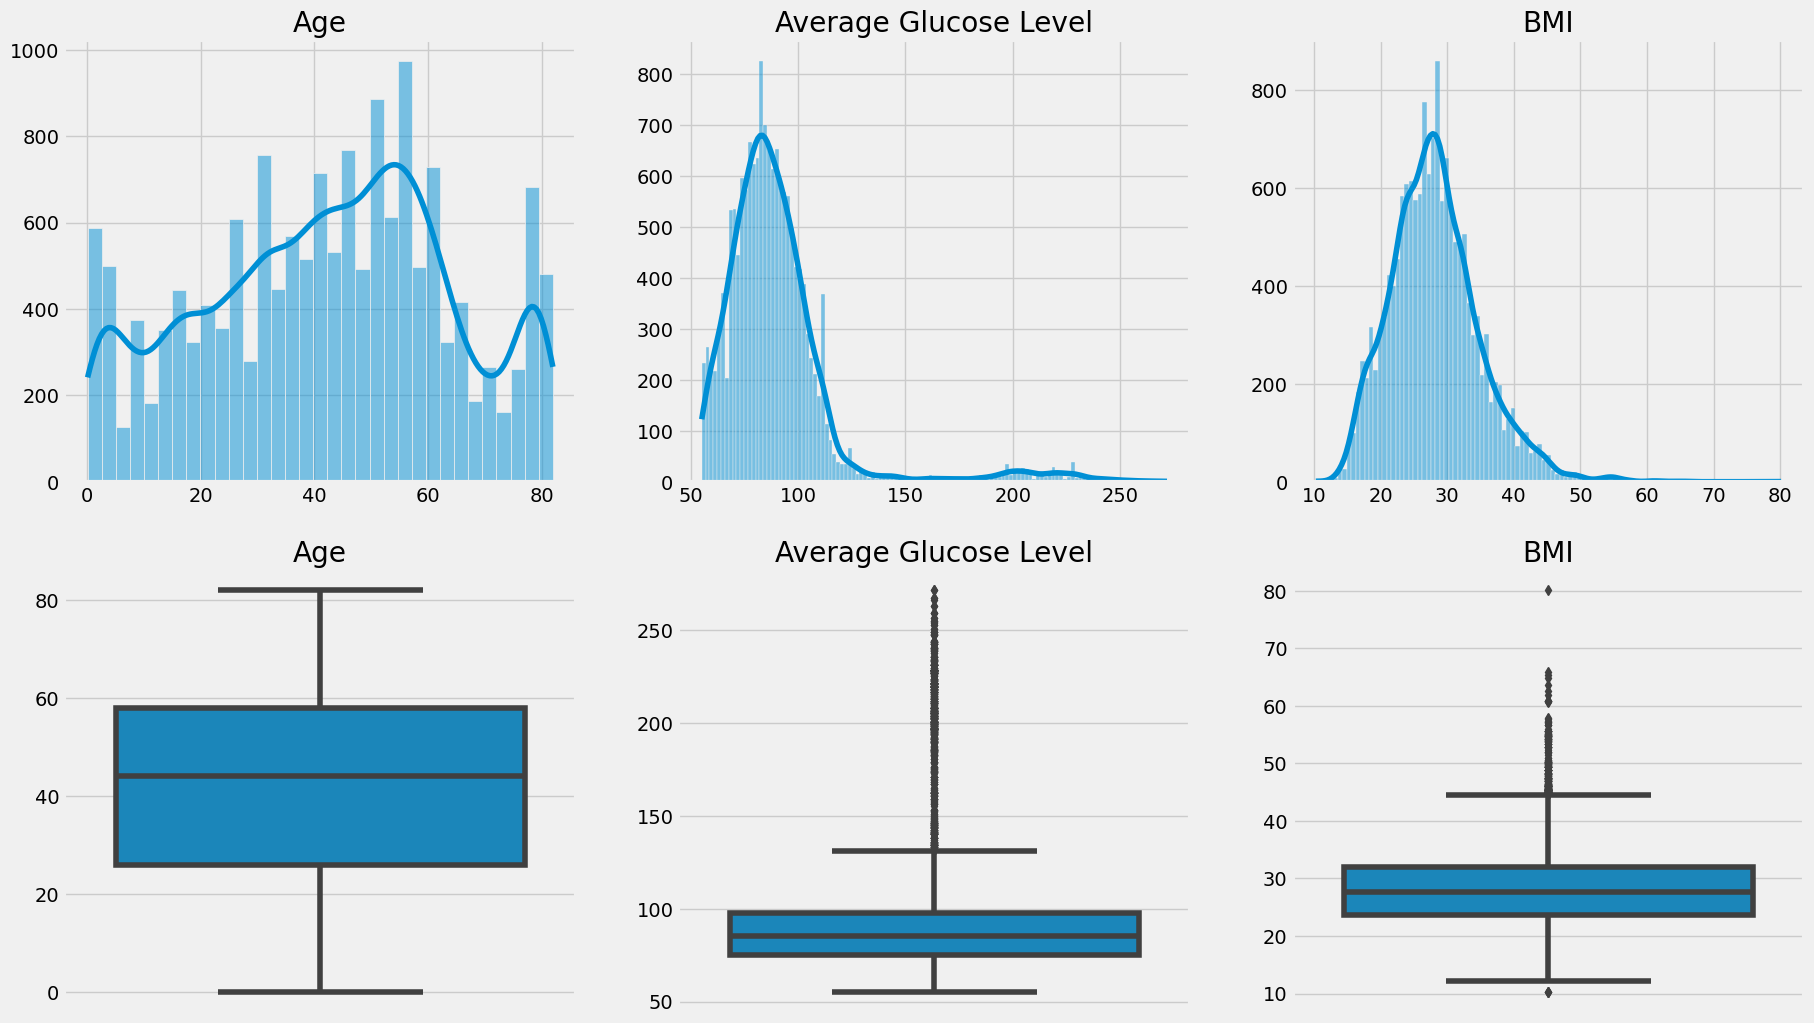

In [46]:
fig, axes = plt.subplots(2,3, figsize=(20,12))
x1 = sns.histplot(ax=axes[0, 0], x='age', fill=True, data=train, kde=True)
x2 = sns.histplot(ax=axes[0, 1], x='avg_glucose_level', fill=True, data=train, kde=True)
x3 = sns.histplot(ax=axes[0, 2], x='bmi', fill=True, data=train, kde=True)
x4 = sns.boxplot(ax=axes[1, 0], y='age', data=train)
x5 = sns.boxplot(ax=axes[1, 1], y='avg_glucose_level', data=train)
x6 = sns.boxplot(ax=axes[1, 2], y='bmi',  data=train)

#plt.title(col, size=18, y=1.03, fontname='Calibri', fontweight='bold', color='#444444')

x1.set(title="Age")
x1.set(xlabel=None)    
x1.set(ylabel=None)

x2.set(title="Average Glucose Level")
x2.set(xlabel=None)    
x2.set(ylabel=None)

x3.set(title="BMI")
x3.set(xlabel=None)    
x3.set(ylabel=None)

x4.set(title="Age")
x4.set(xlabel=None)    
x4.set(ylabel=None
      )
x5.set(title="Average Glucose Level")
x5.set(xlabel=None)    
x5.set(ylabel=None)

x6.set(title="BMI")
x6.set(xlabel=None)    
x6.set(ylabel=None);

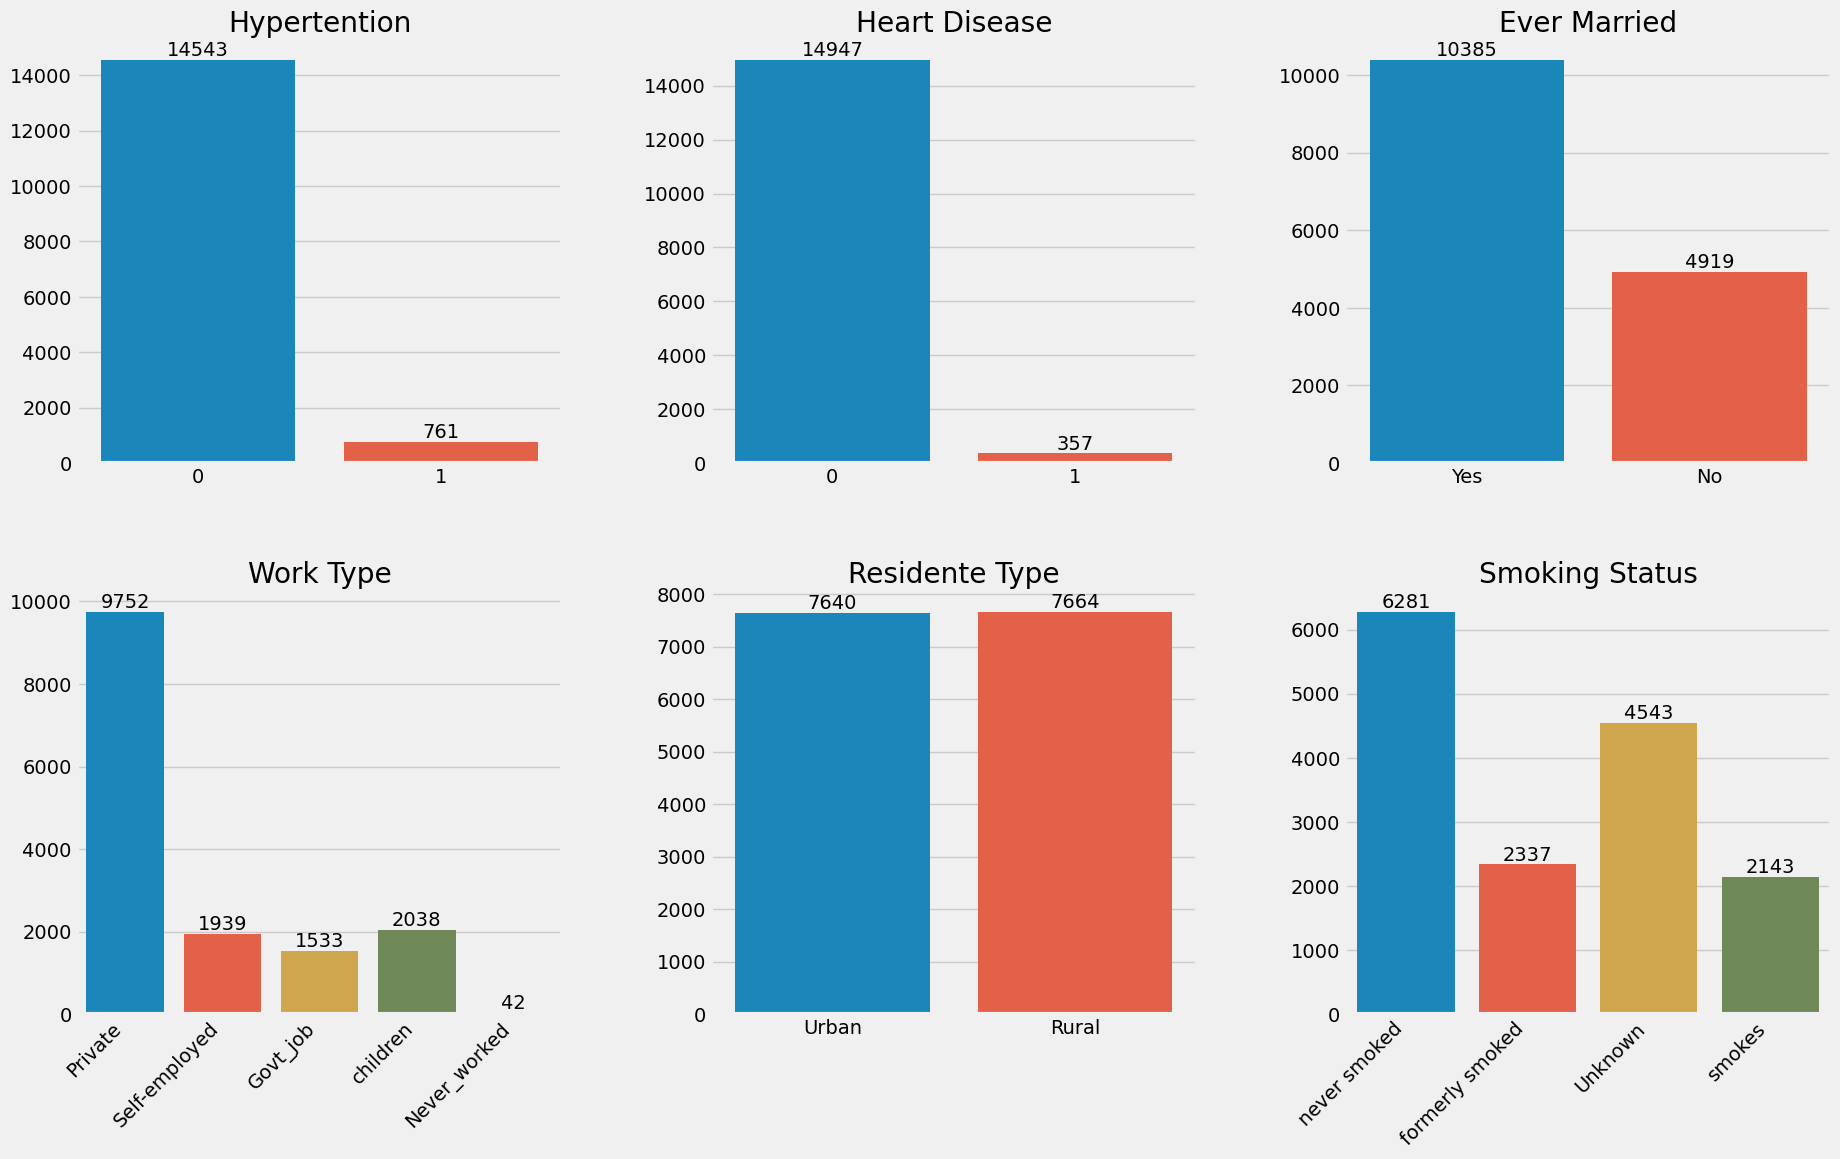

In [13]:
fig, axes = plt.subplots(2,3, figsize=(20,12))
fig.tight_layout(pad=5.0)
x1 = sns.countplot(ax=axes[0, 0], x='hypertension', data=train)
x2 = sns.countplot(ax=axes[0, 1], x='heart_disease', data=train)
x3 = sns.countplot(ax=axes[0, 2], x='ever_married', data=train)
x4 = sns.countplot(ax=axes[1, 0], x='work_type', data=train)
x5 = sns.countplot(ax=axes[1, 1], x='Residence_type', data=train)
x6 = sns.countplot(ax=axes[1, 2], x='smoking_status', data=train)


for container in x1.containers:
    x1.bar_label(container)

for container in x2.containers:
    x2.bar_label(container)
    
for container in x3.containers:
    x3.bar_label(container)

for container in x4.containers:
    x4.bar_label(container)
    
for container in x5.containers:
    x5.bar_label(container)

for container in x6.containers:
    x6.bar_label(container)    
    
x1.set(title="Hypertention")
x1.set(xlabel=None)    
x1.set(ylabel=None)

x2.set(title="Heart Disease")
x2.set(xlabel=None)    
x2.set(ylabel=None)

x3.set(title="Ever Married")
x3.set(xlabel=None)    
x3.set(ylabel=None)

x4.set(title="Work Type")
x4.set(xlabel=None)    
x4.set(ylabel=None)
x4.set_xticklabels(x4.get_xticklabels(), rotation=45, horizontalalignment='right')

x5.set(title="Residente Type")
x5.set(xlabel=None)    
x5.set(ylabel=None)

x6.set(title="Smoking Status")
x6.set(xlabel=None)    
x6.set(ylabel=None)
x6.set_xticklabels(x6.get_xticklabels(), rotation=45, horizontalalignment='right');

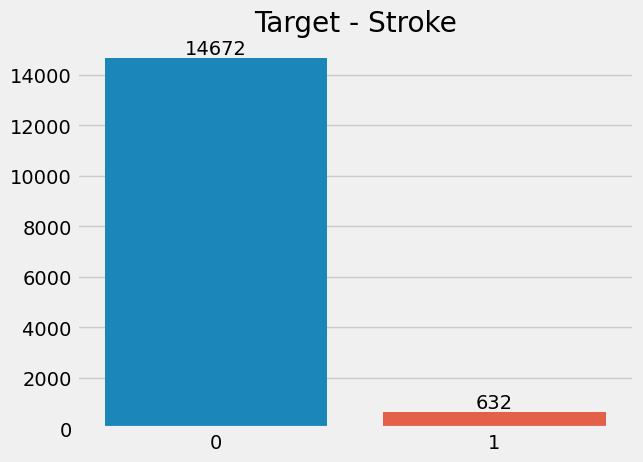

In [14]:
x1 = sns.countplot(x='stroke', data=train)
for container in x1.containers:
    x1.bar_label(container)  
    
x1.set(title="Target - Stroke")
x1.set(xlabel=None)    
x1.set(ylabel=None);

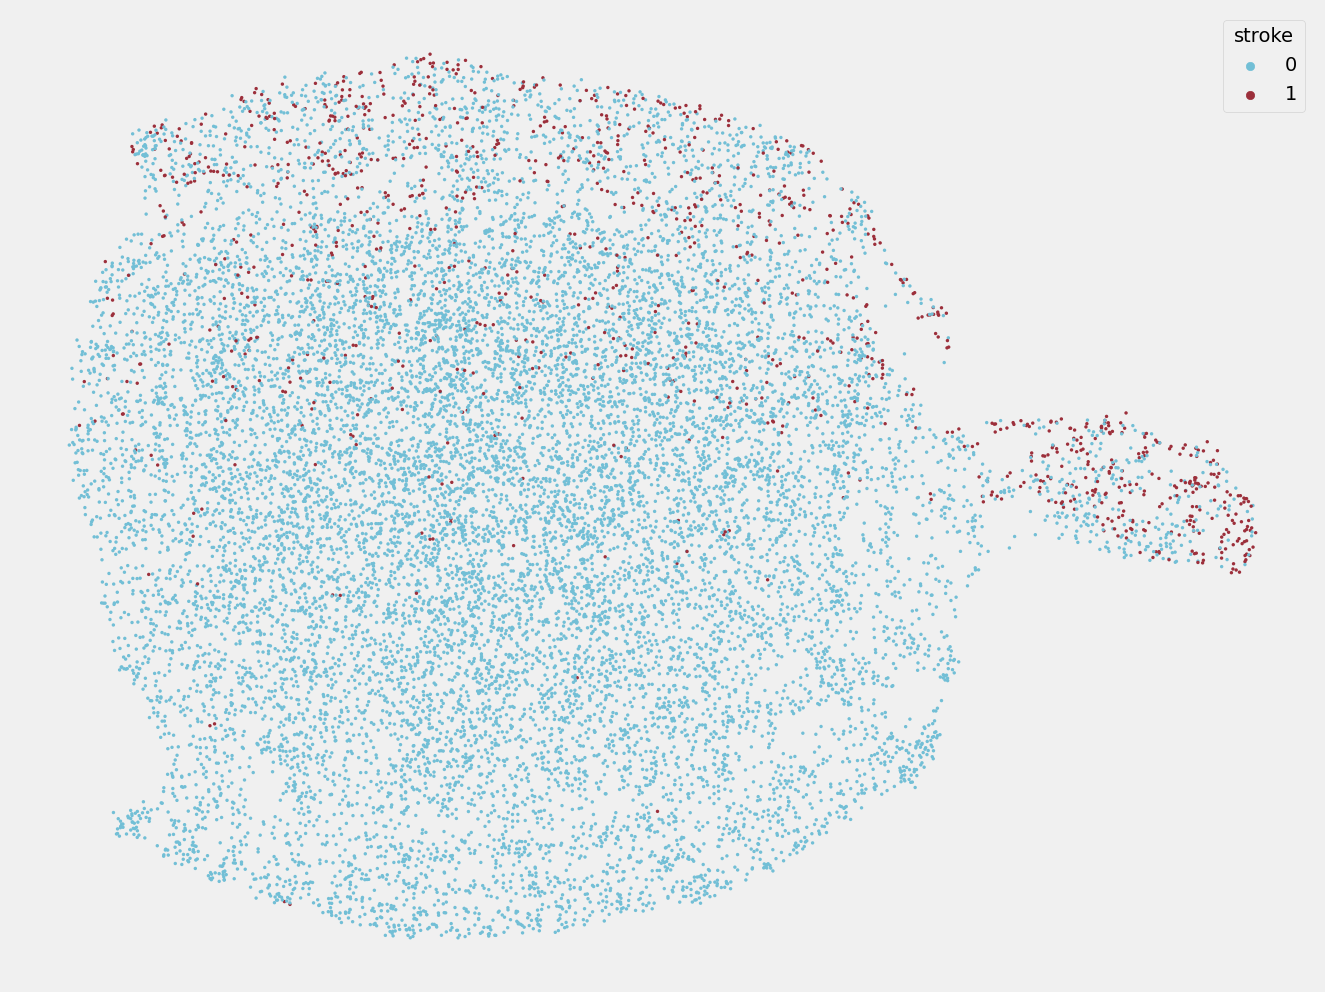

In [53]:
umap = UMAP(n_components=2, n_neighbors=50, min_dist=1, random_state=seed)
results=umap.fit_transform(df.drop('stroke', axis=1))

plt.figure(figsize=(15, 12))
a = sns.scatterplot(x=results[:,0], y=results[:,1], hue=df['stroke'], s=6, edgecolor='none', palette=['#72bfd6', '#9c2f3b'])
plt.xticks([])
plt.yticks([])
plt.show()

<a id="4"></a>
# <b>4 </b><b> <span style='color:#F1C40F'>|</span> Pre Processing</b>

# 

In [35]:
extra_data = extra_data[extra_data['stroke']==1]
train = pd.concat([extra_data, train], ignore_index=True)
df = train.copy()

In [36]:
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.6,1,1
1,0,61.0,0,0,1,3,0,202.21,34.1,2,1
2,1,80.0,0,1,1,2,0,105.92,32.5,2,1
3,0,49.0,0,0,1,2,1,171.23,34.4,3,1
4,0,79.0,1,0,1,3,0,174.12,24.0,2,1


In [ ]:
for col in cat_cols:
    le = LabelEncoder()
    test[col] = le.fit_transform(test[col])

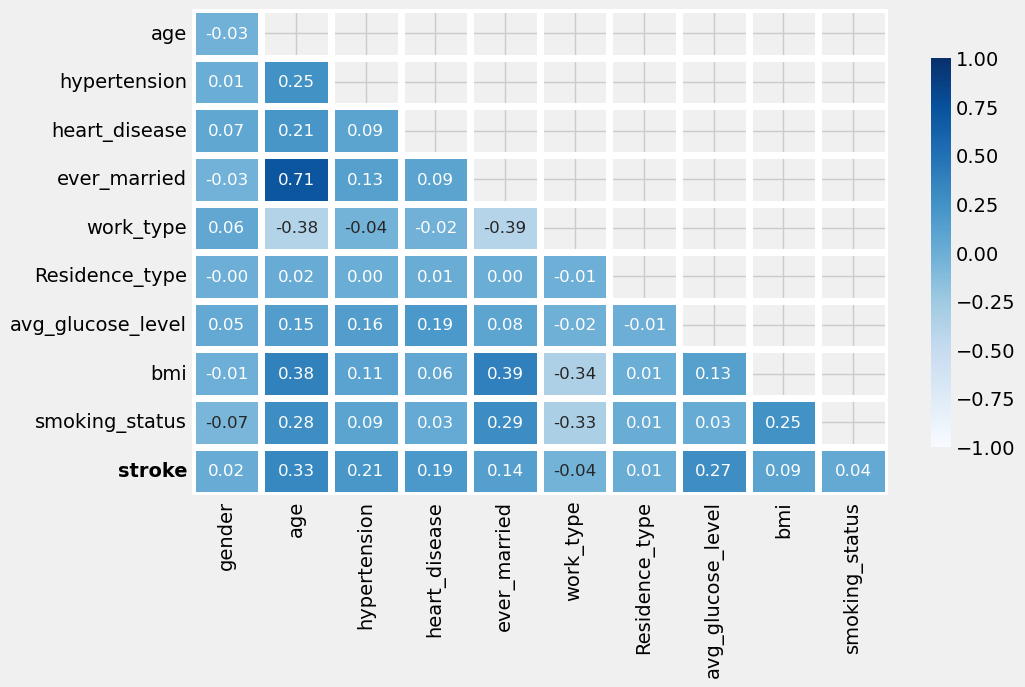

In [45]:
df_corr = df.corr()
fig, ax = plt.subplots(figsize=(10, 6))
mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()
sns.heatmap(corr, mask=mask, fmt=".2f", cmap='Blues',vmin=-1, vmax=1, annot=True, annot_kws={'fontsize': 12}, cbar_kws={"shrink": .8}, linewidths=5,)
plt.yticks(rotation=0)
plt.yticks()[-1][-1].set_fontsize(14)
plt.yticks()[-1][-1].set_fontweight('bold')
plt.show()

In [58]:
mapper = UMAP().fit(df)
outlier_scores = LocalOutlierFactor(contamination=0.001428).fit_predict(mapper.embedding_)
outlier = df[outlier == -1]
vl = outlier.index.values.tolist()
vl.reverse()

df2 = df.copy()
for v in range(len(vl)):
    df2 = df2.drop(index=df2.iloc[v].name)

In [103]:
for col in cat_cols:
    le = LabelEncoder()
    test[col] = le.fit_transform(test[col])

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,0,57.0,0,0,1,2,0,82.54,33.4,0
1,1,70.0,1,0,1,2,1,72.06,28.5,0
2,0,5.0,0,0,0,4,1,103.72,19.5,0
3,0,56.0,0,0,1,0,1,69.24,41.4,3
4,1,32.0,0,0,1,2,0,111.15,30.1,3


In [104]:
train_cb = pd.get_dummies(df2)

X_cb = train_cb.drop('stroke', axis=1)
y_cb = train_cb['stroke']

seed = 33
FOLDS = 10

<a id="5"></a>
# <b>5 </b><b> <span style='color:#F1C40F'>|</span> Model</b>

<a id="51"></a>
# <b>5.1 </b><b> <span style='color:#F1C40F'>|</span> CatBoost</b>

In [106]:
cb_params = {
    'depth': 3,
    'learning_rate': 0.01,
    'rsm': 0.5,
    'subsample': 0.931,
    'l2_leaf_reg': 69,
    'min_data_in_leaf': 20,
    'random_strength': 0.175,    
    'random_seed': seed,
    'use_best_model': True,
    'task_type': 'CPU',
    'bootstrap_type': 'Bernoulli',
    'grow_policy': 'SymmetricTree',
    'loss_function': 'Logloss',
    'eval_metric': 'AUC'
}

f_imp = pd.DataFrame({'feature': X.columns})
predictions, scores = np.zeros(len(test)), []

k = StratifiedKFold(n_splits=FOLDS, random_state=seed, shuffle=True)
for fold, (train_idx, val_idx) in enumerate(k.split(X_cb, y_cb)):    
    cb_train = cb.Pool(data=X_cb.iloc[train_idx], label=y_cb.iloc[train_idx])
    cb_valid = cb.Pool(data=X_cb.iloc[val_idx], label=y_cb.iloc[val_idx])
    
    model = cb.train(params=cb_params, dtrain=cb_train, num_boost_round=10000,
                     evals=cb_valid, early_stopping_rounds=500, verbose=False)
    
    f_imp['fold_'+str(fold+1)] = model.get_feature_importance()
    val_preds = model.predict(cb_valid)
    val_score = roc_auc_score(y_cb.iloc[val_idx], val_preds)
    scores.append(val_score)
    
    predictions += model.predict(test) / FOLDS
    print(f'- FOLD {fold+1} AUC: {round(val_score, 4)} -')
    
    del cb_train, cb_valid, val_preds, val_score, model
    gc.collect()

print('*'*45)
print(f'Mean AUC:',round(np.mean(scores), 4))

- FOLD 1 AUC: 0.8966 -
- FOLD 2 AUC: 0.9028 -
- FOLD 3 AUC: 0.9022 -
- FOLD 4 AUC: 0.9077 -
- FOLD 5 AUC: 0.8945 -
- FOLD 6 AUC: 0.9047 -
- FOLD 7 AUC: 0.9035 -
- FOLD 8 AUC: 0.8928 -
- FOLD 9 AUC: 0.9049 -
- FOLD 10 AUC: 0.9106 -
*********************************************
Mean AUC: 0.902


NameError: name 'norm_0to1' is not defined

<a id="52"></a>
# <b>5.2 </b><b> <span style='color:#F1C40F'>|</span> Tensorflow</b>

In [109]:
X = df2.drop('stroke', axis=1)
y = df2['stroke']


sc = StandardScaler()
X[num_cols] = sc.fit_transform(X[num_cols])
test[num_cols] = sc.transform(test[num_cols])

X = X.values
y = y.values
test = test.values

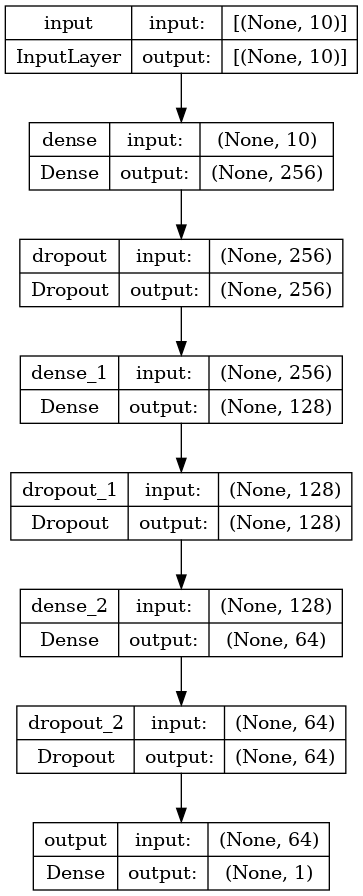

In [110]:
def my_model():
    x_input = Input(shape=(X.shape[-1]), name='input')
    x1 = Dense(256, activation='relu')(x_input)
    d1 = Dropout(0.1)(x1)
    x2 = Dense(128, activation='relu')(d1)
    d2 = Dropout(0.1)(x2)
    x3 = Dense(64, activation='relu')(d2)
    d3 = Dropout(0.1)(x3)
    output = Dense(1, activation='sigmoid', name='output')(d3)
    
    model = Model(x_input, output, name='nn_model')
    return model

model = my_model()
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
VERBOSE = False
BATCH_SIZE = 32
predictions, scores = [], []

lr = ReduceLROnPlateau(monitor='val_auc', factor=0.7, patience=5, verbose=VERBOSE)

es = EarlyStopping(monitor='val_auc', patience=15, verbose=VERBOSE, mode='max', restore_best_weights=True)

k = StratifiedKFold(n_splits=FOLDS, random_state=seed, shuffle=True)
for fold, (train_idx, val_idx) in enumerate(k.split(X, y)):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
        
    model = my_model()
    model.compile(optimizer='adam', loss=tfa.losses.SigmoidFocalCrossEntropy(alpha=0.1, gamma=3), metrics='AUC')
        
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=300, verbose=VERBOSE,
              batch_size=BATCH_SIZE, class_weight={0: 1, 1: 10}, callbacks=[lr, es])
        
    y_pred = norm_0to1(model.predict(X_val))
    val_score = roc_auc_score(y_val, y_pred)
    scores.append(val_score)
    
    predictions.append(model.predict(test))
    print(f'- FOLD {fold+1} AUC: {round(val_score, 4)} -')
    
print(f'Mean AUC:',round(np.mean(scores), 4))

319/319 [==============================] - 0s 1ms/step
- FOLD 1 AUC: 0.8954 -
319/319 [==============================] - 0s 1ms/step
- FOLD 2 AUC: 0.8917 -
319/319 [==============================] - 0s 1ms/step
- FOLD 3 AUC: 0.8882 -
319/319 [==============================] - 0s 1ms/step
- FOLD 4 AUC: 0.9042 -
319/319 [==============================] - 0s 1ms/step
- FOLD 5 AUC: 0.8852 -
319/319 [==============================] - 0s 1ms/step
- FOLD 6 AUC: 0.8961 -


In [1]:
 conda install -c anaconda tensorflow-gpu 